# Random Forest Model Interpretation 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

# Load In Our Data From Last Session

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance
For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [7]:
set_rf_samples(50000)

In [8]:
m = RandomForestRegressor(n_estimators=40, n_jobs= -1, min_samples_leaf=3, max_features= 0.5)
m.fit(X_train, y_train)
print_score(m)

[0.20607333703392025, 0.24718155256766108, 0.91124794169787871, 0.89088609832227228]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the relative confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [9]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 1.8 s


(9.2667390336762985, 0.30888878084899157)

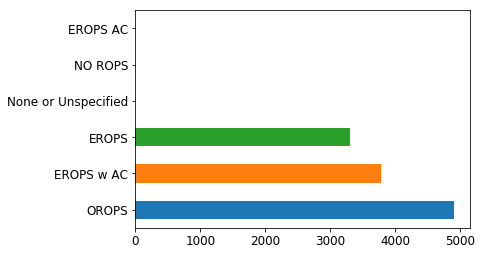

In [10]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [11]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.841445,0.270647
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.580650,0.259141
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.683589,0.221386


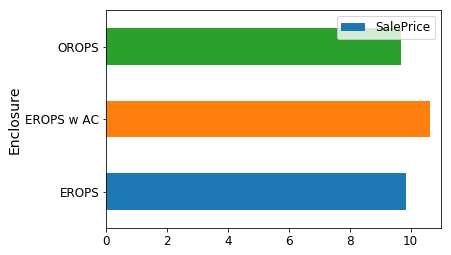

In [12]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

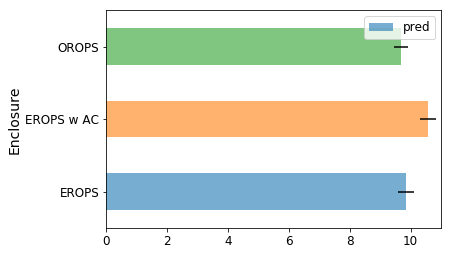

In [13]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

### Question: Why are the predictions nearly exactly right, but the error bars are quite wide?

ANSWER: 

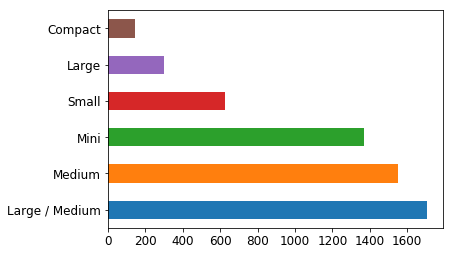

In [14]:
#Product Size
raw_valid.ProductSize.value_counts().plot.barh();

In [15]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.829941,0.339413
Large,10.470589,10.388629,0.347433
Large / Medium,10.691871,10.652792,0.292539
Medium,10.681511,10.626296,0.279354
Mini,9.535147,9.562741,0.242338
Small,10.324448,10.322990,0.310391


In [ ]:
(summ.pred_std/summ.pred).sort_values(ascending=False)
#Telling us that Large and Compact are having the worst prediction and looking at the histogram and our group is small
#We would expect this to be the case with not a lot of observations to predict

## Feature importance
It's not normally enough to just to know that a model can make accurate predictions - we also want to know how it's making predictions. The most important way to see this is with feature importance.

In [17]:
fi = rf_feat_importance(m, df_trn);fi[:10]

,cols,imp
5,YearMade,0.174552
13,ProductSize,0.099435
37,Coupler_System,0.094334
14,fiProductClassDesc,0.084624
2,ModelID,0.061027
38,Grouser_Tracks,0.057269
63,saleElapsed,0.050276
10,fiSecondaryDesc,0.043346
39,Hydraulics_Flow,0.040905
8,fiModelDesc,0.031714


C:\Users\Jerem\Anaconda3\envs\fastai\lib\site-packages\pandas\core\indexes\base.py:1743: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


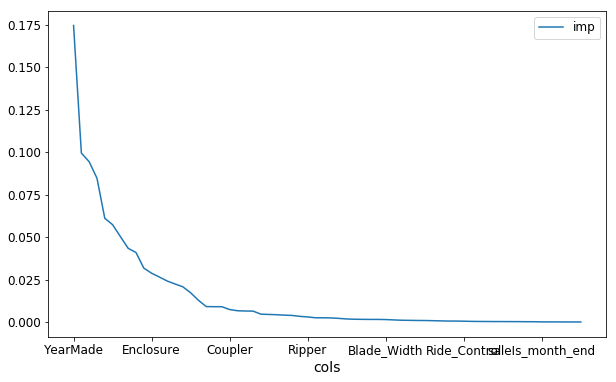

In [18]:
fi.plot('cols', 'imp', figsize=(10,6), legend=True);

In [19]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

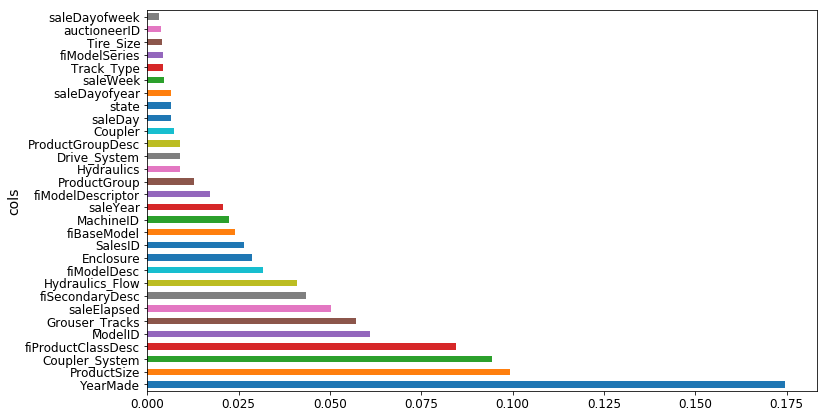

In [20]:
plot_fi(fi[:30]);

In [21]:
#looking 
to_keep = fi[fi.imp > 0.005].cols; len(to_keep)

24

In [22]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [23]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20705656543615167, 0.2462883902069927, 0.91039900389698047, 0.89167321495896268, 0.89396492853266096]


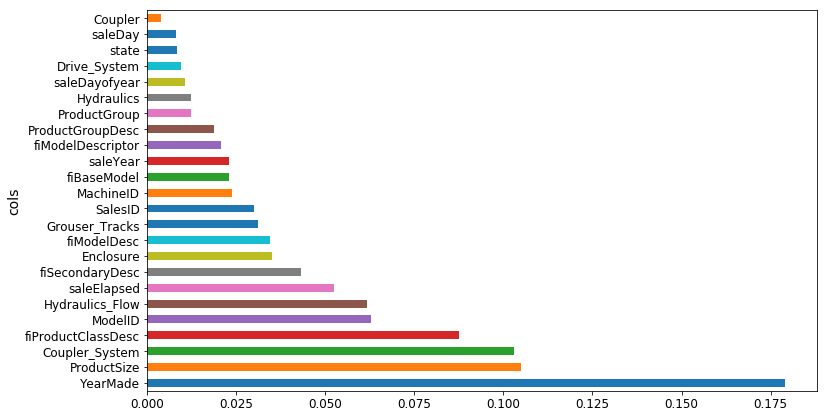

In [24]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

# One-Hot Encoding

Catergorical Variables 'High' 'Low' 'Medium'
mapped to 0,1,2
#changing the order #Inplace will just get rid of the old and make one if false it will have the new and old

    -df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
    
We may have many levels of the category like very low, low, medium, high, very high, unknown could be out of order and we need to order them, but then we can just get rid of this issue with using this technique. Now everything is very low or not: is low or not:etc

    - If an effort was made to make ordinals 
        - df_raw.UsageBand = df_raw.UseageBand.cat.codes **Changes the cat to an int and proc_df will not change it**

In [25]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat = 7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20694924401846101, 0.25435296763904175, 0.91049186367953594, 0.88446286550065101, 0.89284199123382835]


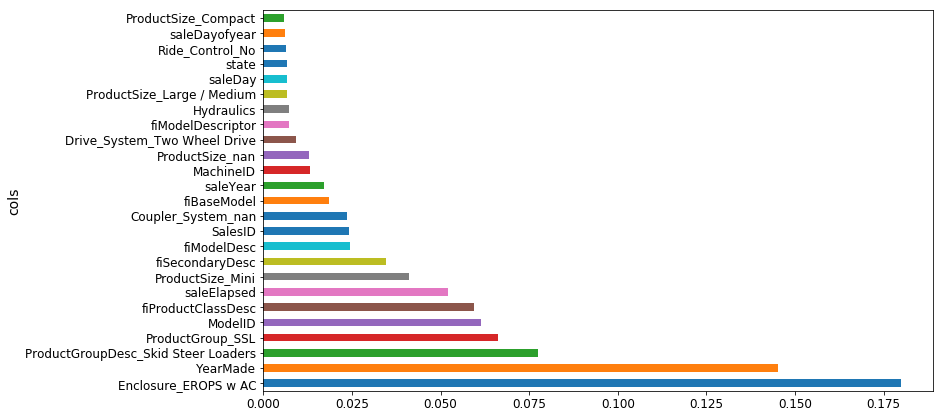

In [26]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

In [27]:
fi = rf_feat_importance(m, df_trn2); fi[:10]

,cols,imp
67,Enclosure_EROPS w AC,0.179905
5,YearMade,0.145135
55,ProductGroupDesc_Skid Steer Loaders,0.077354
48,ProductGroup_SSL,0.066233
2,ModelID,0.061501
12,fiProductClassDesc,0.059392
32,saleElapsed,0.051970
43,ProductSize_Mini,0.041219
9,fiSecondaryDesc,0.034555
7,fiModelDesc,0.024579


# Removing Redundant Features

*One thing that makes this harder to interpret is that there seems to be some variables with very similar meanings. We are trying to get a cluster analysis to have an understanding

In [28]:
from scipy.cluster import hierarchy as hc

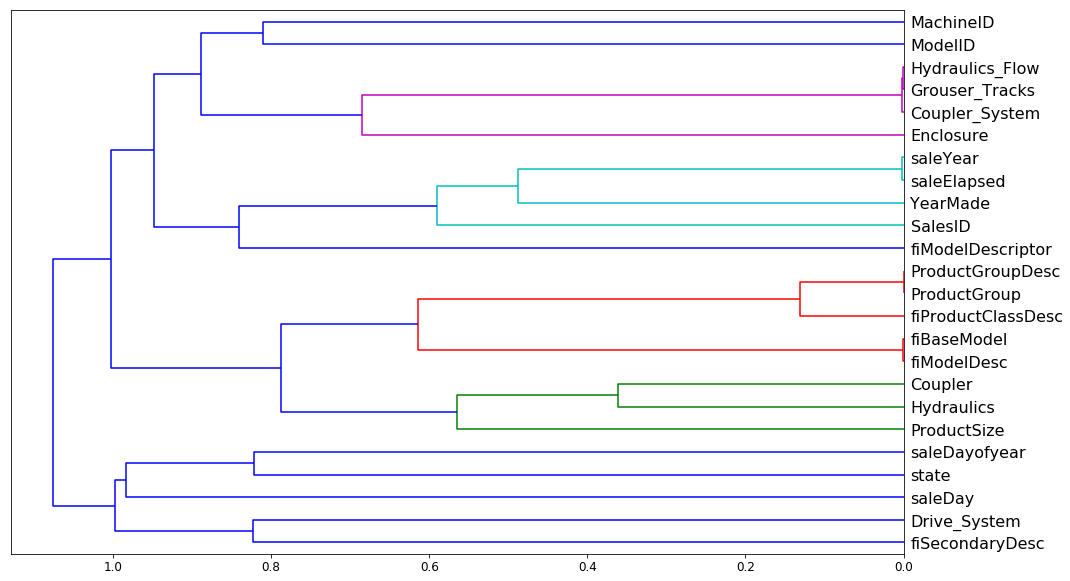

In [29]:
#using the corelation spearman rank correlation
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [30]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [31]:
get_oob(df_keep)

0.88946754626891178

In [32]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.888632003998
saleElapsed 0.886297421978
fiModelDesc 0.888144761819
fiBaseModel 0.888895417246
Grouser_Tracks 0.890669664411
Coupler_System 0.889319781721


In [33]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.88873211022870002

In [34]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [35]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [36]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [37]:
#Restart sample and use all the data
reset_rf_samples()

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12588102527407438, 0.22676748828189383, 0.96688266592584649, 0.90816472020190675, 0.90873937245909386]


# Partial Dependence

How do the important features and understand how the react with the dependent variables

In [39]:
from pdpbox import pdp
from plotnine import *

In [40]:
set_rf_samples(50000)

In [41]:
# when having a hot end code it makes it easier to interpert
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

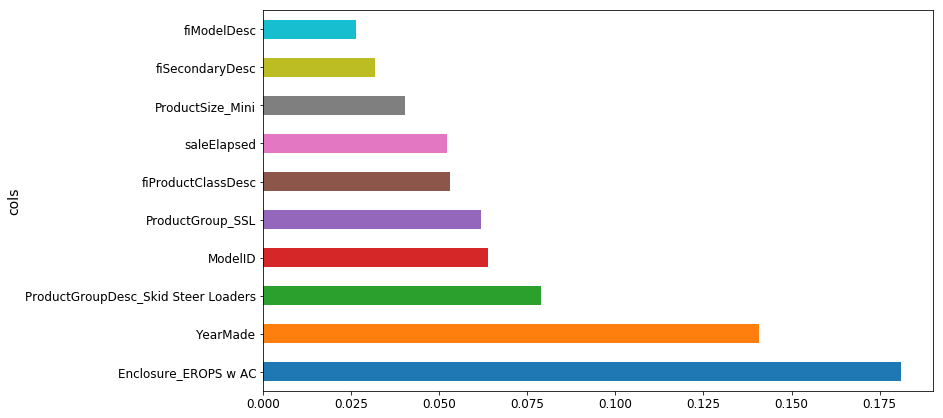

In [42]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

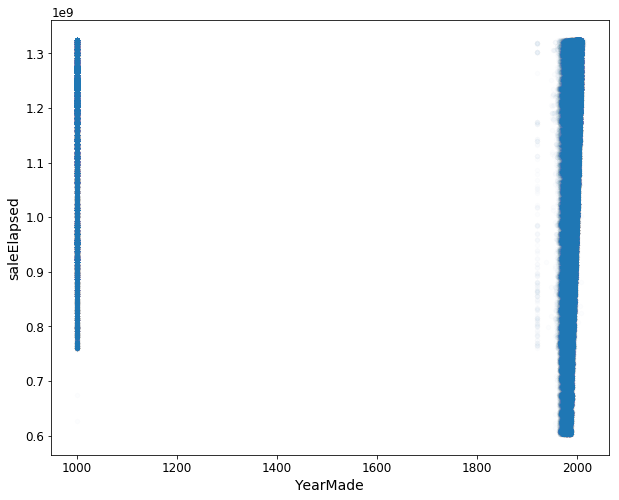

In [43]:
# we can see that year made has year 1000 a ton we need to go back and ask

df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [44]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

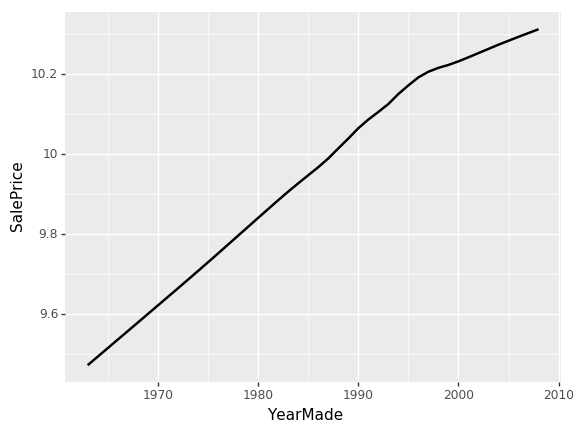

<ggplot: (93823260592)>

In [45]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method ="lowess")

In [46]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [47]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

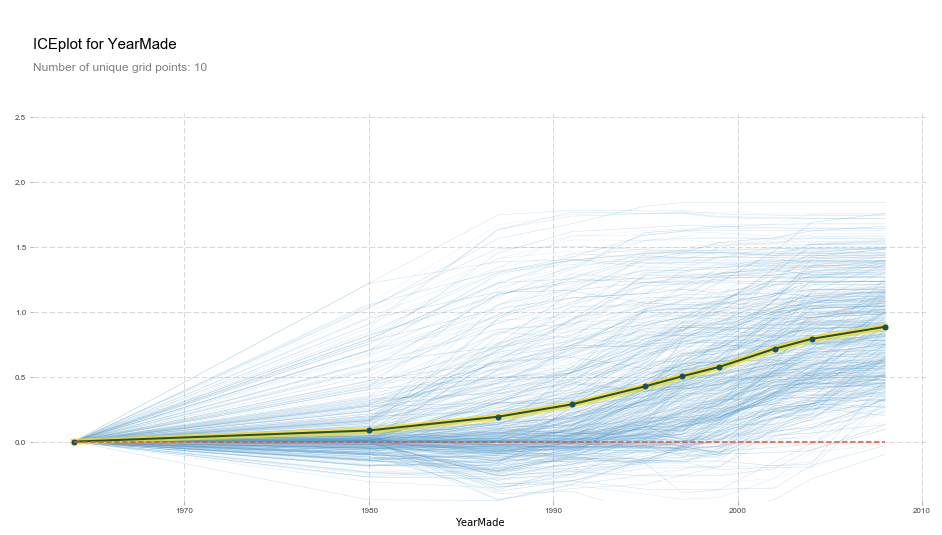

In [48]:
plot_pdp('YearMade')

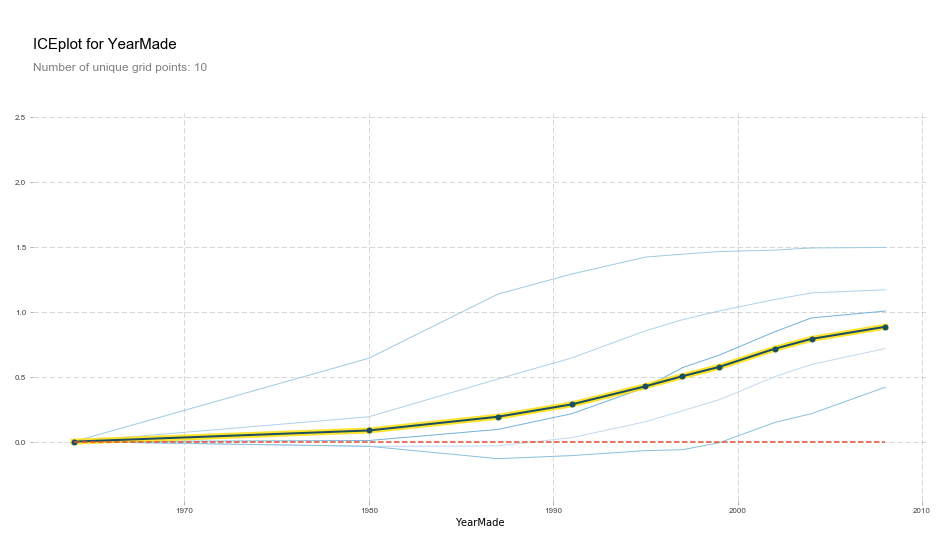

In [49]:
plot_pdp('YearMade', clusters=5)

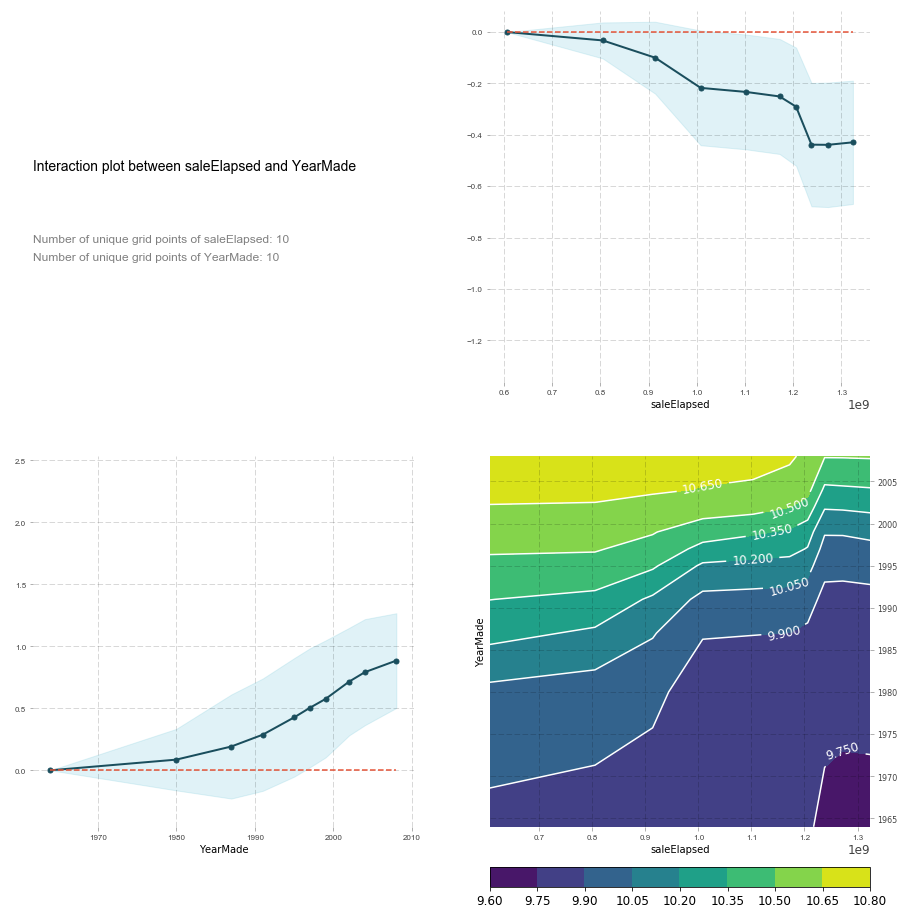

In [50]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

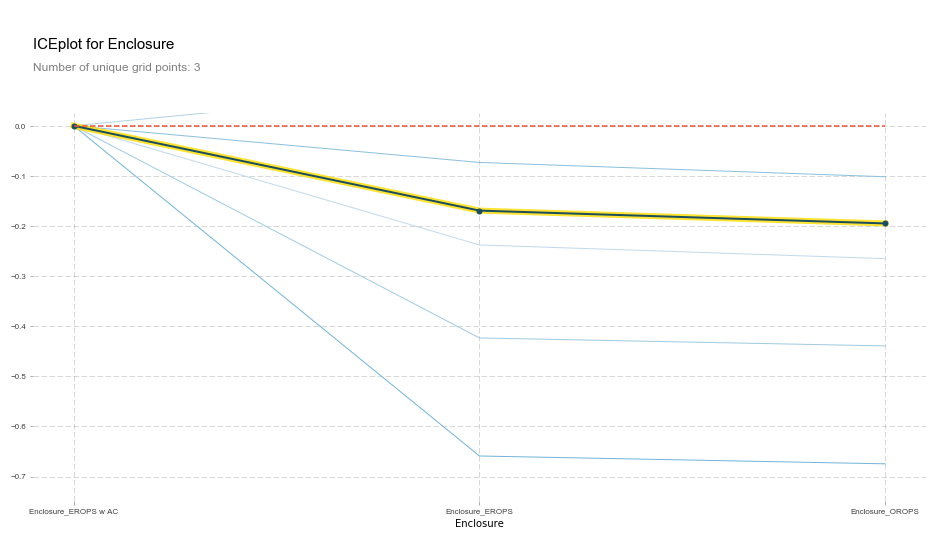

In [51]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [52]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

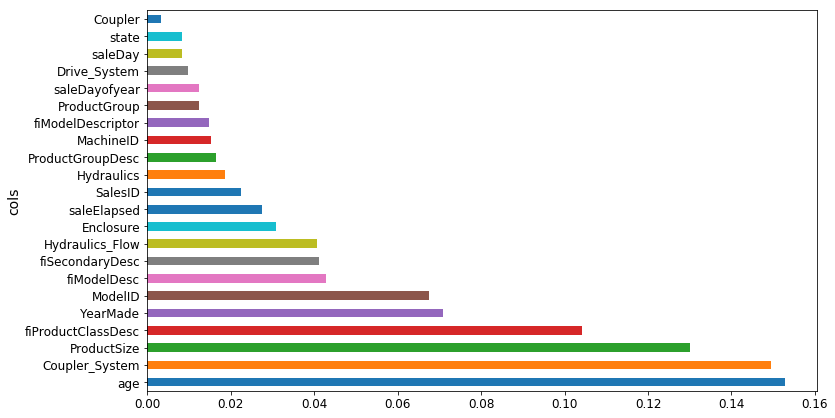

In [53]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree Interpreter (Real Life Important)

In [54]:
from treeinterpreter import treeinterpreter as ti

In [55]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [56]:
row = X_valid.values[None,0]; row

array([[      1999,          5,          0,         17,        665, 1284595200,          0,          0,
              3232,          1,    4364751,    2300944,          0,          4,         12,          0,
                 4,          3,         16,         35,        259,         11]], dtype=int64)

In [57]:
prediction, bias, contributions = ti.predict(m, row)

In [58]:
prediction[0], bias[0]

(9.2509011820441316, 10.105265353979586)

In [59]:
idxs = np.argsort(contributions[0])

In [60]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.52259715603081491),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.15075228400782334),
 ('age', 11, -0.13980514423931978),
 ('fiModelDesc', 'KX1212', -0.12575016079072091),
 ('fiSecondaryDesc', nan, -0.072039687623253815),
 ('MachineID', 2300944, -0.026365816061830482),
 ('saleElapsed', 1284595200, -0.02498989387402455),
 ('saleDayofyear', 259, -0.022393621595260749),
 ('Enclosure', 'EROPS', -0.019505886204641554),
 ('fiModelDescriptor', nan, -0.017108296394698373),
 ('SalesID', 4364751, -0.012265569690994526),
 ('state', 'Ohio', -0.0072639964305289519),
 ('saleDay', 16, -0.0032721352515808098),
 ('Drive_System', nan, 0.00053106154264876966),
 ('Hydraulics', 'Standard', 0.0033294053680055667),
 ('ProductGroup', 'TEX', 0.0083306956164098007),
 ('Coupler', 'None or Unspecified', 0.012663077300569458),
 ('Hydraulics_Flow', nan, 0.015943076211498354),
 ('ProductGroupDesc', 'Track Excavators', 0.016292497478212022),
 ('YearM

In [61]:
contributions[0].sum()

-0.85436417193545333

In [71]:
df_keep.shape, df_valid.shape, contributions.shape, df_raw.shape, prediction.shape, bias.shape, row.shape

((401125, 22), (12000, 22), (1, 22), (401125, 66), (1,), (1,), (1, 22))

In [72]:
X_valid.shape

(12000, 22)

# Extrapolation

Looking at oob_score and validation score should let you know there might be something wrong

In [62]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas= proc_df(df_ext, 'is_valid')

In [63]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99999501402306012

In [64]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.782314
5,saleElapsed,0.127995
11,MachineID,0.073878
20,saleDayofyear,0.006049
4,ModelID,0.002184
8,fiModelDesc,0.002039
0,YearMade,0.001448
9,Enclosure,0.001358
6,fiSecondaryDesc,0.000678
2,Coupler_System,0.000655


In [65]:
#We are looking to take time out of the equation time is almost 100x more important
feats=['SalesID', 'saleElapsed', 'MachineID']

In [86]:
#looking at the data 
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [87]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [91]:
#lets see what else important & drop those 'x' is df
x.drop(feats, axis=1, inplace=True)

In [92]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9788744157058273

In [93]:
#This is looking at the importance and looking at top 10 again
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.230076
0,YearMade,0.193423
17,saleDayofyear,0.147496
4,ModelID,0.079345
7,fiModelDesc,0.063811
13,saleDay,0.060701
14,state,0.056652
3,fiProductClassDesc,0.033542
5,fiSecondaryDesc,0.022893
6,Enclosure,0.022445


In [ ]:
set_rf_samples(50000)

In [94]:
#Again you can see our random forest is being completed with a time element and we want to see if we can 
#scale the project with out time in it and if we can perfect if not we will go back to the drawing board
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [95]:
#Before we iter through with out the 'feats' lets remember what we got before
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2078851286233422, 0.24779522006302876, 0.9096804695455007, 0.8903436405777583, 0.8930864171675403]


In [96]:
#this is goint to take feats and make a rdf with out each one 
for f in feats:
    #this is going to drop one variable from the list 1 at a time to see if validation score goes up or not
    #looking for time dependent variables that don't actually generalize the data
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.2093866243296662, 0.24551689169007151, 0.9083710527504799, 0.8923508194226044, 0.8922017078841176]
saleElapsed
[0.21412424584598114, 0.2558754258809754, 0.9041777159035078, 0.883075605109796, 0.8871364424389397]
MachineID
[0.2068257433044317, 0.24626325170436322, 0.9105986630096503, 0.8916953275253895, 0.8949806564056071]
age
[0.20935547959662418, 0.2475469334437234, 0.9083983089983153, 0.8905632781208878, 0.8918455496406149]
YearMade
[0.20871868757497733, 0.25226809399657024, 0.9089547072707556, 0.8863491663206764, 0.8924874769982005]
saleDayofyear
[0.20869339975812265, 0.2454290563415362, 0.9089767675591005, 0.8924278301069843, 0.8930026646792226]


In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

Final Model

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)